# BBT045: Sequencing Technologies Tutorial

Author: Vi Varga (Adapted from Filip Buric (adapted from Rui Pereira))

Last updated: 11.01.2024


## Tutorial Overview

- Working with Jupyter Notebooks to construct reproducible procedures
- Running sequence processing software from the command line
- Running sequence processing software from wrapper Python modules
- Inspecting different output formats


## Initial setup: Work environment and Data

The starter notebook contains instructions for setting up your `conda` environment. Please follow these instructions, then continue using the notebook to write the commands used here and take notes for the exercises. You can also download a copy from [here](seq_tech_tutorial_py.ipynb) for your own computer.

The notebook will serve as both a rudimentary pipeline and final (reproducible) report.

![Notebook usage example](img/notebook_usage.drawio.png)

If you have not done so already, you need to first install `conda`. See instructions [here](../unix/conda_install.html)


## Directory and data setup

We will be working in Jupyter Lab and primarely writing the commands in this Jupyter Notebook. However, the first commands in this section are easier if you run from the terminal. (Note that depending on how you have things set up on your computer, you may have access to a Unix terminal within Jupyter Lab. Simply do: "File" → "New" → "Terminal" and a terminal will open in a new tab in Jupyter Lab.)

Please create a directory for this tutorial in your home directory and inside there copy the starter notebook from my directory. To do this run the following commands in the terminal after logging on to the server:

```bash
cd
mkdir 
cd NGS_Tutorial
wget https://bengtssonpalme.github.io/MPBIO-BBT045-2024/seq_tech/seq_tech_tutorial_py.ipynb
###
# optionally, if you want the images to show up properly
cp -r /cephyr/NOBACKUP/groups/bbt045_2024/data/img/ .
```

Now fetch a copy of the data we will be using:

```bash
cp /cephyr/NOBACKUP/groups/bbt045_2024/data/data.zip .
# and now decompress the .zip file
unzip data.zip -d data/
# and clean up
rm -r __MACOSX/
# this directory is an artifact of the .zip file creation process
# it's unnecessary, so it can be deleted
```

To nicely see the contents of (small) directories, you can use the `tree` program, but you may need to install it first (`conda install tree`)

```bash
tree data
```

You can also run `ls *` (which works on any system).

To make sure this data is protected from accidental writes, remove the write permission (`-w`) for anyone on the server (`ugo`) on it by running:

```bash
find data -type f -print0 | xargs -0 chmod ugo-w
```

Then create a results directory: 

```bash
mkdir results
```


## Work environment

### Background

It's standard practice to create a new `conda` environment for each project. This is because each project may require a number of different software packages, with certain versions. Even if these requirements are very similar between the projects, even small differences may topple the house of cards that is the software ecosystem. This is officially referred to as ["dependency hell"](https://en.wikipedia.org/wiki/Dependency_hell) and can cause you _more than a little_ frustration (to put it _mildly_).

`Conda` can fetch packages from many different sources (aka "channels"). Let's add the Bioconda channel, as well as the general-purpose conda-forge channel ("defaults" is given first to give it top priority when searching for packages).

Ignore any errors about " Inappropriate ioctl for device" and "no job control in this shell". They're a harmless consequence of this.

Add the channels by running the following in your Unix terminal (not in your Jupyter Notebook):

```bash
# adding conda channels
conda config --add channels defaults
conda config --add channels bioconda
conda config --add channels conda-forge
```

### Setting up our environment

Create and activate a new environment for this exercise. 

The `conda create` command creates new environments, the option `--name` (or `-n`) specifies the name of your new environment and the option `-y` lets `conda` know that you answer "yes" to all prompts. Without `-y` you will have to manually type in "yes" or "y" when prompted.

The command `conda activate` activates the environment within the current code chunk **and only the current code chunk**. Which means that within every code chunk that we want to use our environment we need to first run `conda activate <environment_name>`. 

Create and activate the `conda` environment used for this exercise by running the following in your Unix terminal (not in your Jupyter Notebook):

```bash
conda create --name sequencing -y
# you can activate the environment by running: 
conda activate sequencing
```

### Installing relevant software

Now install the software needed for this exercise. We want to install the software on to our new environment so we first activate the environment with `conda activate`. The command `conda install` will install the packages that you specify to it. You can specify multiple packages at a time by separating them with spaces. This step will also ask for confirmation if we do not specify the `-y` option. 

Later on/in real life, it's good to to examine what changes are made when installing new packages. You can easily view all the packages installed in an environment by running `conda list` once the environment is activated. 

**Make sure you activated the `sequencing` environment!**

Once again, run the following lines of code from your Unix terminal: 

```bash
conda activate sequencing
# conda install gsl==2.5 samtools bowtie2 breseq abyss bcftools wgsim emboss tree ncurses -y
# you can often install all packages in a conda environment as shown above
# however in this case, it's actually quicker to run multiple commands: 
conda install gsl==2.5
# this is necessary to prevent a dependency issue with bcftools
# ref: https://www.biostars.org/p/9480029/#9573995
conda install -c bioconda samtools
conda install -c bioconda bowtie2 
conda install -c bioconda breseq 
conda install -c bioconda abyss 
conda install -c bioconda bcftools 
conda install -c bioconda wgsim 
conda install -c bioconda emboss 
conda install tree
conda install -c conda-forge ncurses
# otherwise ncurses may install without a version number, which will cause samtools to raise an error
# ref: https://stackoverflow.com/questions/72103046/libtinfo-so-6-no-version-information-available-message-using-conda-environment
# and install a few python libraries
conda install pandas seaborn
```

Lets inspect the packages that we just installed.

```bash
conda activate sequencing
conda list
```

### Running `conda` in Jupyter Notebooks

Because Jupyter is packaged within an Anaconda installation, you should be able to run `conda` commands directly from this Jupyter Notebook with just a little modification. Simply install the IPython kernel in any environment you wish to use in Jupyter Notebooks, **and** the `nb_conda_kernels` program in your `base` `conda` environment. Do this now in your Unix terminal, where you have the `sequencing` environment activated. 

**PLEASE NOTE!!!** Enable the creation of a kernel only _after_ you have installed all of the programs you intend to install in your environment! Starting with the `ipykernel` installation can raise errors that will prevent you from installing the programs you are actually going to use in your environment! 

```bash
# do this inside of your working conda environment, not in the base environment
conda install ipykernel
```

Now create a kernel for the `conda` environment, by running the following in that same Unix terminal: 

```bash
# you can run this from the base conda environment
python -m ipykernel install --user --name=sequencing
# this should return soemthing like: 
# Installed kernelspec sequencing in /home/vivarga/.local/share/jupyter/kernels/sequencing
```

For more information, check out [this website](https://saturncloud.io/blog/how-to-use-conda-environment-in-a-jupyter-notebook/).

Once you have installed the above in your environment, you also need to install the `nb_conda_kernels` program in your `base` `conda` environment: 

```bash
# in base conda environment
conda install conda-forge::nb_conda_kernels
# ref: https://stackoverflow.com/questions/39604271/conda-environments-not-showing-up-in-jupyter-notebook/56409235#56409235
```

You should now be able to activate the `sequencing` `conda` environment within this Jupyter Notebook, by selecting the `Python [conda env:sequencing]` kernel within Jupyter Lab. Since you will be working within a kernel made from your `conda` environment, there will be no need to run `conda activate sequencing` in any of the cells in this Notebook. (There should also be a `sequencing` kernel, but you likely won't be able to run programs installed in the environment using this kernel.) This can be done either from the kernel display at the top right side of the Jupyter Lab screen, or via "Kernel" → "Change Kernel..." → select the kernel of choice

![Two options for changing the kernel](img/select_kernel.png)

![Kernel selection popup](img/select_kernel_dropdown.png)

If this doesn't work, please ask for help so we make sure we all start from the same place.

## Exercise 1: Alignment

We'll be aligning sequencing data against the reference genome of a Varicella virus.

![](img/align_to_ref.png)

This mainly involves using `bowtie2` to align short-read sequencing data to the reference genome and `samtools` to post-process and visualize the result:

Raw data files:
- Varicella reference genome: `data/ref/varicella.gb`
- Sequencing files: `data/seq/varicella1.fastq`, `data/seq/varicella2.fastq`

You can run the commands in the terminal directly to test them out, but they should be included (in order) in the Jupyter Notebook, so copy the code chunks and run the chunk from the notebook. The next code block demonstrates how to run bash commands from a Jupyter Notebook.

## Protocol

### Step 1: Init

Create a separate results directory, using either the command line, or your Jupyter Notebook. In your `bash` terminal, you can run: 

```bash
mkdir results/exercise1
```

Alternately, you can run the folloing directly from your Jupyter Notebook. (Note the "! " at the start of the line; this tells Jupyter to execute the commands on that line on the command line, rather than in Python.)

In [1]:
# run bash commands from Jupyter Notebook with an ! at the start of the line
! mkdir results/exercise1

### Step 2: Preprocess

`bowtie2` requires an index file for the reference sequence. This index can only be constructed from a FASTA file but it's common practice to find reference genomes in GenBank (GFF3) format.

Convert `varicella.gb` to FASTA using the [seqret](http://emboss.sourceforge.net/apps/cvs/emboss/apps/seqret.html) converter from the EMBOSS package, then build the bowtie index accordingly.

> (Computation time: seconds)

In [2]:
# Convert GFF3 > FASTA
! seqret -sequence data/ref/varicella.gb -feature -fformat gff3 -osformat fasta data/ref/varicella.fasta

# This file is outptut by seqret in the current directory (because bad design)
# So we move it where it belongs
! mv varicella.gff data/ref/

# Document how the FASTA file was created
! touch data/ref/README.txt
! echo "vaircella.fasta converted from GFF as:" > data/ref/README.txt
! echo "seqret -sequence data/ref/varicella.gb -feature -fformat gff3 -osformat fasta data/ref/varicella.fasta" >> data/ref/README.txt

# Save index files in own directory
! mkdir results/exercise1/bowtie_index
# Build the bowtie2 index
! bowtie2-build -f data/ref/varicella.fasta results/exercise1/bowtie_index/varicella

Read and write (return) sequences
Settings:
  Output files: "results/exercise1/bowtie_index/varicella.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/ref/varicella.fasta
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 31221
Using parameters --bmax 23416 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with 

### Step 3: Align sequences to reference

Align the sequencing data to the reference genome using `bowtie2`. This will create the file `varicella.sam`. The `\` symbol simply breaks the command across multiple lines for readability.

> (Computation time: 1 min)

In [3]:
! mkdir results/exercise1/alignment
! bowtie2 -x results/exercise1/bowtie_index/varicella -1 data/seq/varicella1.fastq -2 data/seq/varicella2.fastq -S results/exercise1/alignment/varicella.sam

50000 reads; of these:
  50000 (100.00%) were paired; of these:
    24692 (49.38%) aligned concordantly 0 times
    22163 (44.33%) aligned concordantly exactly 1 time
    3145 (6.29%) aligned concordantly >1 times
    ----
    24692 pairs aligned concordantly 0 times; of these:
      21725 (87.98%) aligned discordantly 1 time
    ----
    2967 pairs aligned 0 times concordantly or discordantly; of these:
      5934 mates make up the pairs; of these:
        4 (0.07%) aligned 0 times
        262 (4.42%) aligned exactly 1 time
        5668 (95.52%) aligned >1 times
100.00% overall alignment rate


### Step 4: Convert alignment to binary format

To make reading the alignment info easier for the computer,
convert the sequence alignment map (SAM) file to binary alignment map (BAM)
using the `samtools` `view` command:

> (Computation time: seconds)

In [4]:
! samtools view -b -S -o results/exercise1/alignment/varicella.bam results/exercise1/alignment/varicella.sam

### Step 5: Optimize alignment (pt 1)

To optimize the lookup in the alignment map,
sort the BAM file using `samtools sort` command.
This will create the file `varicella.sorted.bam`

> (Computation time: seconds)

In [5]:
! samtools sort results/exercise1/alignment/varicella.bam -o results/exercise1/alignment/varicella.sorted.bam

### Step 6: Optimize alignment (pt 2)

To speed up reading the BAM file even more,
index the sorted BAM file using `samtools` `index` command:

> (Computation time: seconds)

This will create a BAI file called `results/exercise1/alignment/varicella.sorted.bam.bai`

In [6]:
! samtools index results/exercise1/alignment/varicella.sorted.bam

### Step 7: Calculate alignment coverage

Calculate the average coverage of the alignment using the `samtools depth` command and the Unix `awk` text processor to extract the values of interest:

> (Computation time: 1s)

Output should be: 

Answer: 

<font color="white">
`average =  199.775`
</font>

In [7]:
! samtools depth results/exercise1/alignment/varicella.sorted.bam | awk '{sum+=$3} END {print "Average = ", sum/124884}'

Average =  199.775


## Question

Use the `samtools depth` command to extract coverage info and create a coverage map of the genome (position vs. coverage). Read the help for the tool with `samtools help depth`. The output format is described at the end of the help.

Answer:  

In [8]:
! samtools depth results/exercise1/alignment/varicella.sorted.bam > results/exercise1/alignment/coverage.tsv

Plot the result with Python:

In [9]:
# load necessary modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings # module to manage warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # prevent Python from warning of future feature deprecation

<Axes: title={'center': 'Alignment Coverage'}, xlabel='Alignment coverage depth', ylabel='Counts'>

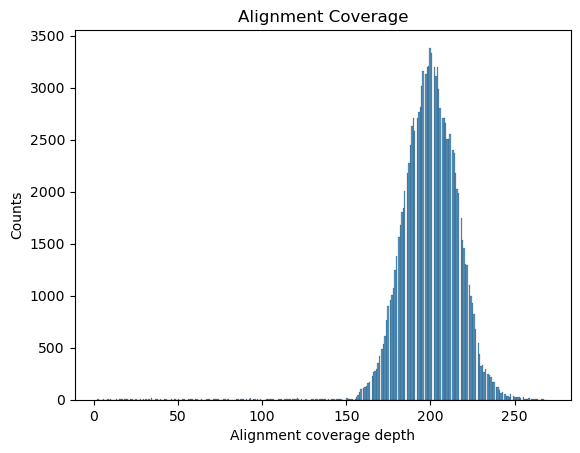

In [10]:
# import data into Pandas dataframe
alignment_coverage_df = pd.read_csv('results/exercise1/alignment/coverage.tsv', sep = '\t', names = ["reference_name", "position", "coverage_depth"])


# create histogram of data
alignment_coverage_plot = sns.histplot(data = alignment_coverage_df, x = "coverage_depth")
# next add labels to the axes & a title
alignment_coverage_plot.set_title('Alignment Coverage')
alignment_coverage_plot.set_ylabel('Counts')
alignment_coverage_plot.set_xlabel('Alignment coverage depth')

# visualize the plot
alignment_coverage_plot

## Exercise 2: Finding Mutations with SAMtools

We now look at a second set of sequencing data, with mutations (`data/seq/varicella_mut1.fastq` and `data/seq/varicella_mut1.fastq`)

![](img/align_mut_to_ref.png)

We'll still be using `bowtie2` and `samtools` to perform these tasks, however we'll be doing structuring all the steps in to one script.

This approach has the great advantage that we don't need to copy-paste all we did above just to change the name of the input files. That's cumbersome and *very* error-prone. Instead we just need to change the file name at one location.

## Protocol


### Step 1: Align sequences to reference

Create a sorted and indexed BAM file using the code below, which encapsulates steps 2-6 from Exercise 1 (except for the GFF > FASTA conversion).

Tip: Run `ls -l data/*` or `tree data` if you forget what files you're working on.

The workflow will also create `results/exercise2` for you.

> (Computation time: 5 minutes)

Note that here I've used `%%bash` at the start of the cell; this is part of IPython's "cell magics". When you start a code cell with `%%`, you can transform the entire cell into a different language, rather than only transforming a single line. So for example, you could do `%%R` to transform a regular Jupyter Notebook code cell (which runs Python by default) into an R code cell. 

In [11]:
%%bash

DATA_DIR=data/seq
RESULT_DIR=results/exercise2

REFERENCE_GENOME=data/ref/varicella.fasta
READS_1=$DATA_DIR/varicella_mut1.fastq
READS_2=$DATA_DIR/varicella_mut2.fastq


BOWTIE_INDEX_DIR=$RESULT_DIR/bowtie_index
ALIGNMENT_DIR=$RESULT_DIR/alignment

# Make all directories
mkdir $RESULT_DIR
mkdir $BOWTIE_INDEX_DIR
mkdir $ALIGNMENT_DIR

# Build the bowtie2 index
bowtie2-build -f $REFERENCE_GENOME $BOWTIE_INDEX_DIR/varicella


bowtie2 -x $BOWTIE_INDEX_DIR/varicella -1 $READS_1 -2 $READS_2 -S $ALIGNMENT_DIR/varicella_mut.sam

samtools view -b -S -o $ALIGNMENT_DIR/varicella_mut.bam $ALIGNMENT_DIR/varicella_mut.sam
    
samtools sort $ALIGNMENT_DIR/varicella_mut.bam -o $ALIGNMENT_DIR/varicella_mut.sorted.bam
    
samtools index $ALIGNMENT_DIR/varicella_mut.sorted.bam

Settings:
  Output files: "results/exercise2/bowtie_index/varicella.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/ref/varicella.fasta
Reading reference sizes


Building a SMALL index


  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 31221
Using parameters --bmax 23416 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 23416 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 12 sample suffixes
Generating random suffixes
QSorting 12 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSorting 12 samples
  (Using dif

Renaming results/exercise2/bowtie_index/varicella.3.bt2.tmp to results/exercise2/bowtie_index/varicella.3.bt2
Renaming results/exercise2/bowtie_index/varicella.4.bt2.tmp to results/exercise2/bowtie_index/varicella.4.bt2
Renaming results/exercise2/bowtie_index/varicella.1.bt2.tmp to results/exercise2/bowtie_index/varicella.1.bt2
Renaming results/exercise2/bowtie_index/varicella.2.bt2.tmp to results/exercise2/bowtie_index/varicella.2.bt2
Renaming results/exercise2/bowtie_index/varicella.rev.1.bt2.tmp to results/exercise2/bowtie_index/varicella.rev.1.bt2
Renaming results/exercise2/bowtie_index/varicella.rev.2.bt2.tmp to results/exercise2/bowtie_index/varicella.rev.2.bt2
50000 reads; of these:
  50000 (100.00%) were paired; of these:
    24692 (49.38%) aligned concordantly 0 times
    22163 (44.33%) aligned concordantly exactly 1 time
    3145 (6.29%) aligned concordantly >1 times
    ----
    24692 pairs aligned concordantly 0 times; of these:
      21725 (87.98%) aligned discordantly 1 t

### Step 2: Identify point mutations

Use the `samtools mpileup` command to identify genomic variants (aka single nucleotide variants, [SNVs](https://en.wikipedia.org/wiki/SNV_calling_from_NGS_data)) in the alignment. This will create the file `varicella_variants.bcf`

In [12]:
! bcftools mpileup -f data/ref/varicella.fasta results/exercise2/alignment/varicella_mut.sorted.bam -O u > results/exercise2/varicella_variants.bcf

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


### Step 3: Inspect mutations (pt 1)

Use `bcftools call` command to convert the binary call format (BCF) to (human-readable) variant call format ([VCF](https://en.wikipedia.org/wiki/Variant_Call_Format)). This will create the file `varicella_variants.vcf`

In [13]:
! bcftools call -c -v results/exercise2/varicella_variants.bcf > results/exercise2/varicella_variants.vcf

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid


If you wish to inspect it, run `less -S results/exercise2/varicella_variants.vcf`.

The file contains quite a lot of information, which we'll use later on. See https://en.wikipedia.org/wiki/Variant_Call_Format for more info.

### Step 4: Inspect mutations (pt 2)

Visualize the mutation detected on site `77985` using the `samtools tview` command.

For this, you only need the BAM file. Remember that this files stores mutant-to-reference alignment information. VCF (and BCF) contain only the information needed for some downstream tasks.

This is an interactive command so **run it in the terminal**:

```bash
samtools tview results/exercise2/alignment/varicella_mut.sorted.bam data/ref/varicella.fasta -p NC_001348:77985 
```

## Questions

### Q1

Inspect the VCF file columns using the Unix command chain:

```bash
# note that this command is also interactive - run it in the terminal
grep -v "^#"  results/exercise2/varicella_variants.vcf | column -t | less -S
```

(Chain: Filter out header | align columns | show on screen)

How can you interpret the [PHRED](https://en.wikipedia.org/wiki/Phred_quality_score) score values in the last column? See [What is a VCF and how should I interpret it?](https://gatkforums.broadinstitute.org/gatk/discussion/1268/how-should-i-interpret-vcf-files-produced-by-the-gatk) (Section 5)

Are all mutations homozygous? Should you expect any heterozygous mutations in this case?

### Q2

What assumption does `samtools mpileup` make about the model of genetic mutations? (Try running `bcftools mpileup` for help and scroll down.) 

Is this model appropriate for a virus?

Answer: 
<font color="white">
samtools mpileup assumes the data originates from a diploid organism
and models mutations based on the existence of two similar copies of the same sequence.
Since viruses only have one copy of the genome, this model is not correct and 
it is not possible for a single genomic position to have two different bases.
</font>

### Q3

Use `samtools mpileup` to inspect the site 73233. What is the frequency of each base on this site?

Run the command below and see [Pileup format](https://en.wikipedia.org/wiki/Pileup_format)

In [14]:
! samtools mpileup -r NC_001348:73233-73233 -f data/ref/varicella.fasta results/exercise2/alignment/varicella_mut.sorted.bam

[mpileup] 1 samples in 1 input files
NC_001348	73233	t	90	,,,.,.g,,,,,,..,,.,,.,,..,..,A,.,.,.,..,.,,..,..,,g..,.,...,...,.,,,,.....,,...,,,.,.,,..^K.	222C2C22222222222222C22222C22222222222222222222222222222222222222222222222222222222C22C222


Answer:  

<font color="white"> 170 T, 1 A, 2 G </font>

## Exercise 3: Finding Mutations with breseq

Using the `breseq` pipeline to compute the mutations present in the mutant strain in comparison to the reference sequence provided for the varicella virus.


## Protocol

### Step 1: Init

Create the results directory for this exercise:

In [15]:
! mkdir results/exercise3

### Step 2: Run

> (Computation time: 5 minutes)

Run `breseq`

In [16]:
! breseq -j 1 -o results/exercise3 -r data/ref/varicella.gb data/seq/varicella_mut*.fastq

breseq 0.38.2     http://barricklab.org/breseq

Active Developers: Barrick JE, Deatherage DE
Contact:           <jeffrey.e.barrick@gmail.com>

breseq is free software; you can redistribute it and/or modify it under the
terms the GNU General Public License as published by the Free Software 
Foundation; either version 2, or (at your option) any later version.

Copyright (c) 2008-2010 Michigan State University
Copyright (c) 2011-2022 The University of Texas at Austin

If you use breseq in your research, please cite:

  Deatherage, D.E., Barrick, J.E. (2014) Identification of mutations
  in laboratory-evolved microbes from next-generation sequencing
  data using breseq. Methods Mol. Biol. 1151: 165–188.

If you use structural variation (junction) predictions, please cite:

  Barrick, J.E., Colburn, G., Deatherage D.E., Traverse, C.C.,
  Strand, M.D., Borges, J.J., Knoester, D.B., Reba, A., Meyer, A.G. 
  (2014) Identifying structural variation in haploid microbial genomes 
  from short-rea

## Questions

### Q1

Open the `index.html` file in the `results/exercise3/output` folder. (Using the File tab in RStudio, navigate to the file, click on it, and choose "Open in browser") and compare the mutations detected, in comparison to exercise 2. 

Answer: 

<font color="white">
One mutation is missing in breseq
</font>

### Q2

Use the `breseq bam2aln` command to investigate the missing mutations

Answer:

<font color="white">
`breseq bam2aln -f data/ref/varicella.fasta -b results/exercise2/alignment/varicella_mut.sorted.bam -r NC_001348:117699-117699 -o results/exercise3/missing_mutations.html`
</font>

Now open the output `results/exercise3/missing_mutations.html` with Jupyter Lab.

Breseq missed this mutation in the output table.

### Q3

Open the `results/exercise3/output/summary.html` file and find the mean coverage of the alignment.

Find also the coverage plot.

# Exercise 4: De novo genome assembly

So far we've been using a reference genome to align reads to it.
When one is not available, the genome has to be assembled *de novo* from the reads.
Here, we'll be using the `abyss` assembler with reads from the *dumas* strain of the varicella virus.

![](img/assembly.png)

Sequencing files from *dumas* strain: `data/varicella_l1.fastq`, `data/varicella_l2.fastq`

## Protocol


### Step 1: Init

In [17]:
! mkdir results/exercise4

### Step 1: Assembly

Assemble the reads provided into a genome using `abyss-pe` for `k=128`

> (Computation time: 5 minutes)

In [18]:
! abyss-pe name=varicella k=128 B=8K --directory=results/exercise4 in='../../data/seq/varicella_l1.fastq ../../data/seq/varicella_l2.fastq'

make: Entering directory '/cephyr/users/viragv/Vera/BBT045-2024/Seq_Tech/results/exercise4'
abyss-stack-size 65536 abyss-bloom-dbg -k128 -q3  -b8K -j1  ../../data/seq/varicella_l1.fastq ../../data/seq/varicella_l2.fastq  > varicella-1.fa
Running with max stack size of 65536 KB: abyss-bloom-dbg -k128 -q3 -b8K -j1 ../../data/seq/varicella_l1.fastq ../../data/seq/varicella_l2.fastq
AdjList    -k128 -m50 --dot varicella-1.fa >varicella-1.dot
abyss-rresolver-short  -b8K -f0.8 -j1 -k128 \
 -h varicella-1-rr --dot -c varicella-1-rr.fa \
-g varicella-1-rr.dot varicella-1.fa varicella-1.dot ../../data/seq/varicella_l1.fastq ../../data/seq/varicella_l2.fastq 
No small resolveable junctions were found!
abyss-filtergraph  --dot   -k128 -g varicella-2.dot1 varicella-1-rr.dot varicella-1-rr.fa >varicella-1-rr.path
MergeContigs --dot   -k128 -g varicella-2.dot -o varicella-2.fa varicella-1-rr.fa varicella-2.dot1 varicella-1-rr.path
PopBubbles  --dot -j1 -k128  -p0.9  -g varicella-3.dot varicella-2.fa

## Questions

### Q1

How many unitigs, contigs and scaffolds were assembled?

Hint: `less varicella-stats.md`

Answer: <font color="white">14, 12, 6</font>

### Q2

How big is the largest scaffold?

Answer: <font color="white">107578</font>

### Q3

Use NCBI nucleotide blast (https://blast.ncbi.nlm.nih.gov/Blast.cgi) to find similar sequences to the scaffolds obtained. 

What is the most similar sequence obtained?